In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras, config
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Reshape

In [20]:
def TrainData():
    real_img = r"archive\test\REAL"
    gan_img = []

    random_real = np.random.choice(os.listdir(real_img), 10000, replace=False)

    for path in tqdm(random_real, desc='Real Training Data'):
        data = cv2.imread(os.path.join(real_img, path))
        gan_img.append(data)

    gan_img = np.array(gan_img).reshape(-1, 32, 32, 3)
    gan_img = gan_img/255
    
    return gan_img

In [21]:
def Generator():
    model = keras.Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    model.summary()
    return model

def Discriminator():
    model = keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    model.summary()
    return model

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
@tf.function
def train_step(image_batch, noise, generator, discriminator, generator_opt, discriminator_opt):
    noise = tf.random.normal([200, noise])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def train(dataset, epochs, noise, generator, discriminator, generator_opt, discriminator_opt):
    for epoch in range(epochs):
        for image_batch in tqdm(dataset, desc='Batch'):
            train_step(image_batch, noise, generator, discriminator, generator_opt, discriminator_opt)

In [24]:
train_gan = TrainData()

Real Training Data: 100%|██████████| 10000/10000 [00:01<00:00, 8011.71it/s]


In [25]:
"""
Tensorflow supports running computations on GPU 

WARNING : You need to have CUDA, cuDNN, and tensorflow with version lower than 2.11.0, 
          if not, DON'T execute this cell.
"""
physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print('Running on GPU available now')

Running on GPU available now


In [26]:
train_gan = tf.data.Dataset.from_tensor_slices(train_gan).shuffle(len(train_gan)).batch(100)

In [27]:
gen = Generator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)       

In [28]:
dis = Discriminator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [29]:
generator_opt = tf.keras.optimizers.Adam(0.0001)
discriminator_opt = tf.keras.optimizers.Adam(0.0001)

In [30]:
train(train_gan, 500, 100, gen, dis, generator_opt, discriminator_opt)

Batch: 100%|██████████| 100/100 [00:04<00:00, 23.69it/s]


2/2 [==============================] - 0s 181ms/step


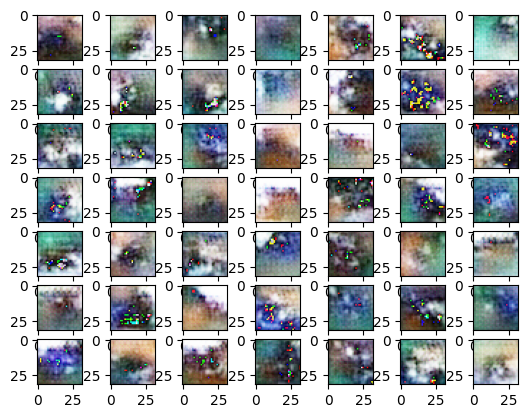

In [8]:
n = tf.random.normal([49, 100])
generated = gen.predict(n)
generated = generated*255
generated = np.array(generated).reshape(-1, 32, 32, 3).astype('uint8')

for i in range(1, 50):
    plt.subplot(7, 7, i)
    plt.imshow(generated[i-1])

In [35]:
gen.save('Models/GAN_generator.h5')

In [4]:
train_generated = gen.predict(tf.random.normal([10000, 100]))
path = 'GAN/train/'
num = 0
train_generated = train_generated*255
for i in train_generated:
    name = path+str(num)+'.jpg'
    cv2.imwrite(name, i)
    num+=1

test_generated = gen.predict(tf.random.normal([5000, 100]))
test_path = 'GAN/test/'
num = 0
test_generated = test_generated*255
for i in test_generated:
    name = test_path+str(num)+'.jpg'
    cv2.imwrite(name, i)
    num+=1

157/157 [==============================] - 1s 3ms/step
